In [1]:
import pandas, numpy, seaborn, scipy

In [2]:
import sklearn, sklearn.preprocessing
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.8, 9 * 0.8)})

In [4]:
input_data_file = '/Users/adrian/gd15/research/vigur/data/targeted.2024.eva/EC_72_EVA_All_ION_MODES.xlsx'

In [5]:
basicdf = pandas.read_excel(input_data_file, sheet_name='BASIC_NEG', index_col='SAMPLE')

# replicate 2

In [6]:
wdf = basicdf[basicdf['LCMS_BATCH_Biological_replicate'] == 2]

['Pool', 'Pool', 'Pool', 7, 8, 9, 10, 11, 12]


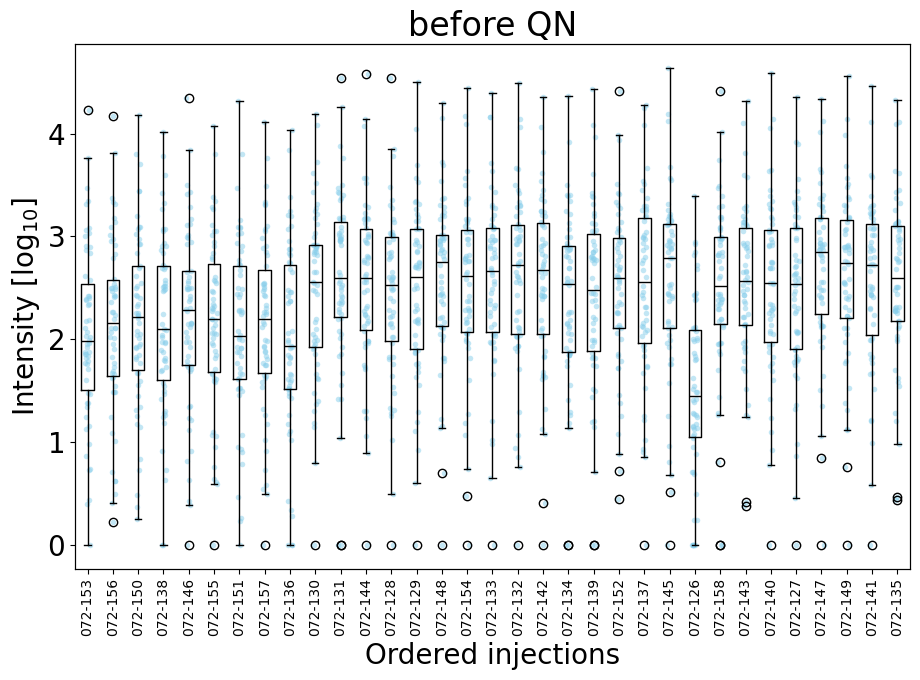

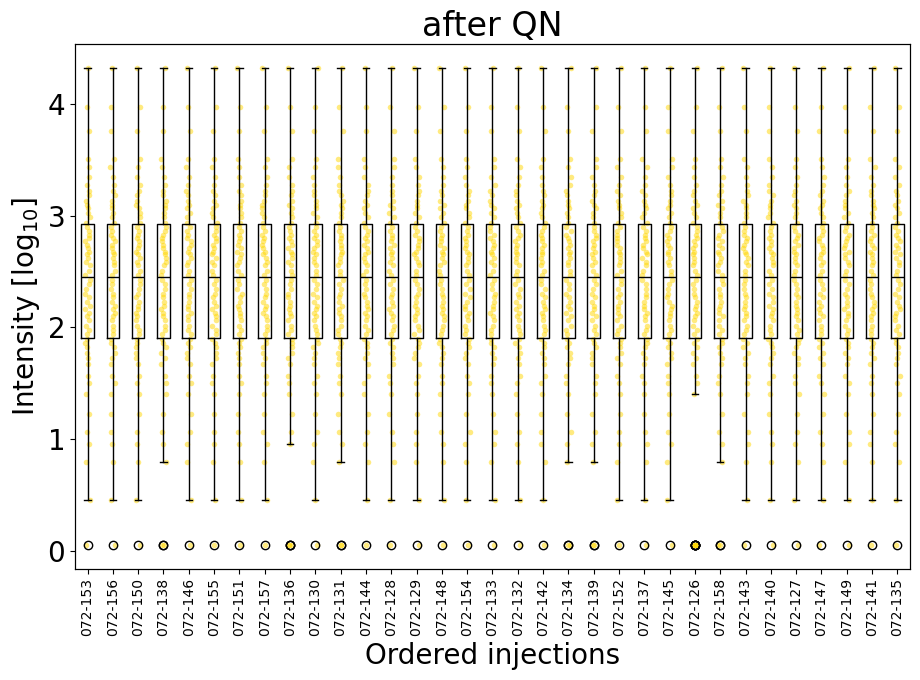

In [7]:
# transform
intensities = wdf.iloc[:, 7:]

rocks = []
for label in wdf.index:
    if isinstance(label, str) == False:
        rocks.append(label)
    else:
        if '072' not in label:
            rocks.append(label)  
print(rocks)
intensities.drop(rocks, axis=0, inplace=True)

intensities = intensities.transpose()
log10_intensities = numpy.log10(intensities + 1)

#plot
ax1 = log10_intensities.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(log10_intensities, color='skyblue', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('before QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10_intensities.values, axis=0), 
                             index=log10_intensities.index, 
                             columns=log10_intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10_intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

# plot after
ax1 = df_qn.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_qn, color='gold', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('after QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

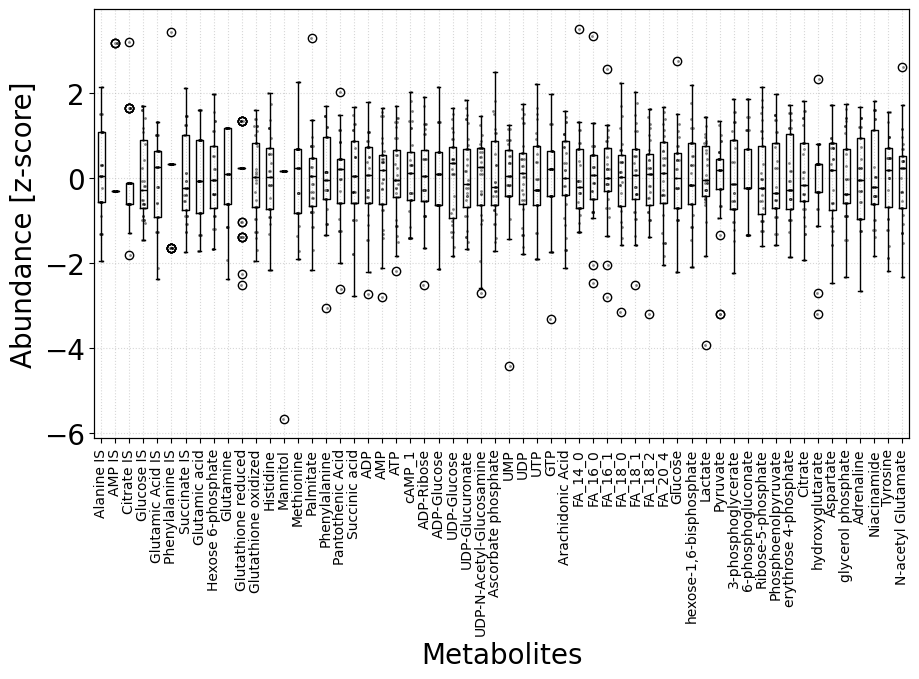

In [8]:
# transpose & scale
t_df_qn = df_qn.transpose()
std_scaler = sklearn.preprocessing.StandardScaler()
df_std = pandas.DataFrame(std_scaler.fit_transform(t_df_qn), columns=t_df_qn.columns, index=t_df_qn.index)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [9]:
print(log10_intensities.loc['AMP IS'].values)
print(df_qn.loc['AMP IS'].values)

[0.         0.40959502 0.25285303 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.44684771 0.         0.
 0.         0.         0.41697317 0.         0.         0.
 0.         0.         0.46775605]
[0.05239612 0.4548679  0.05239612 0.05239612 0.05239612 0.05239612
 0.05239612 0.05239612 0.05239612 0.05239612 0.05239612 0.05239612
 0.05239612 0.05239612 0.05239612 0.05239612 0.05239612 0.05239612
 0.05239612 0.05239612 0.05239612 0.05239612 0.05239612 0.05239612
 0.05239612 0.05239612 0.4548679  0.05239612 0.05239612 0.05239612
 0.05239612 0.05239612 0.4548679 ]


In [10]:
print(log10_intensities.loc['Mannitol'].values)
print(df_qn.loc['Mannitol'].values)

[4.22961837 4.16973279 4.17992325 4.01175279 4.3443843  4.077956
 4.31862194 4.11695657 4.03000948 4.08171083 4.54421324 4.57684716
 4.53921013 4.49968142 4.29822361 4.43961712 4.39484333 4.4958725
 4.3595219  4.36457371 4.43185085 4.41162785 4.27748865 4.63586058
 3.38951391 4.41031957 4.31879897 4.59240379 4.35072685 4.33741253
 4.56086265 4.46380924 4.32554019]
[4.32396945 4.32396945 4.32396945 4.32396945 4.32396945 4.32396945
 4.32396945 4.32396945 4.32396945 3.97909779 4.32396945 4.32396945
 4.32396945 4.32396945 4.32396945 4.32396945 4.32396945 4.32396945
 4.32396945 4.32396945 4.32396945 4.32396945 4.32396945 4.32396945
 4.32396945 4.32396945 4.32396945 4.32396945 4.32396945 4.32396945
 4.32396945 4.32396945 4.32396945]


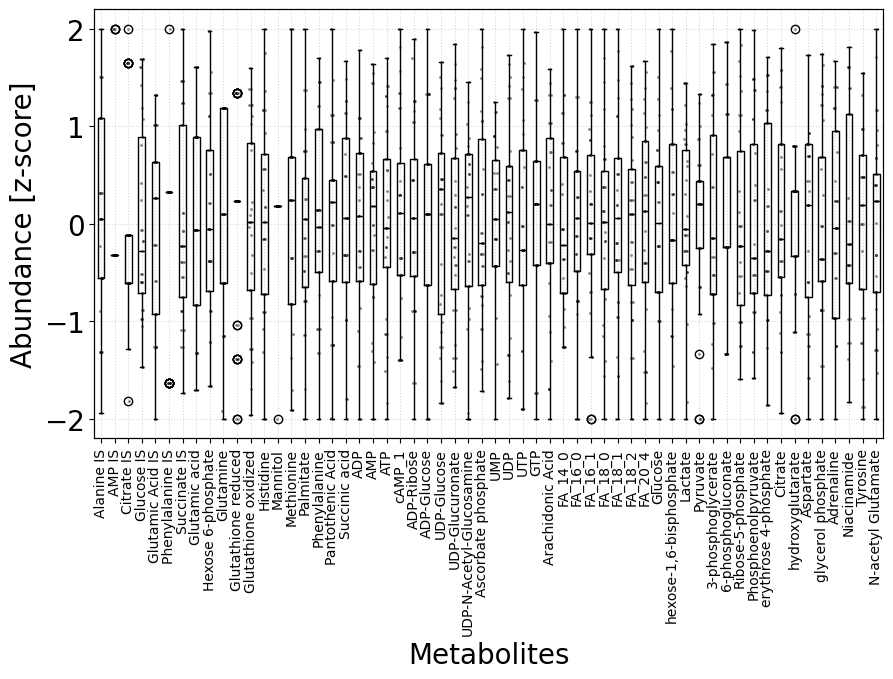

In [11]:
# clip
df_std.clip(-2, 2, inplace=True)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

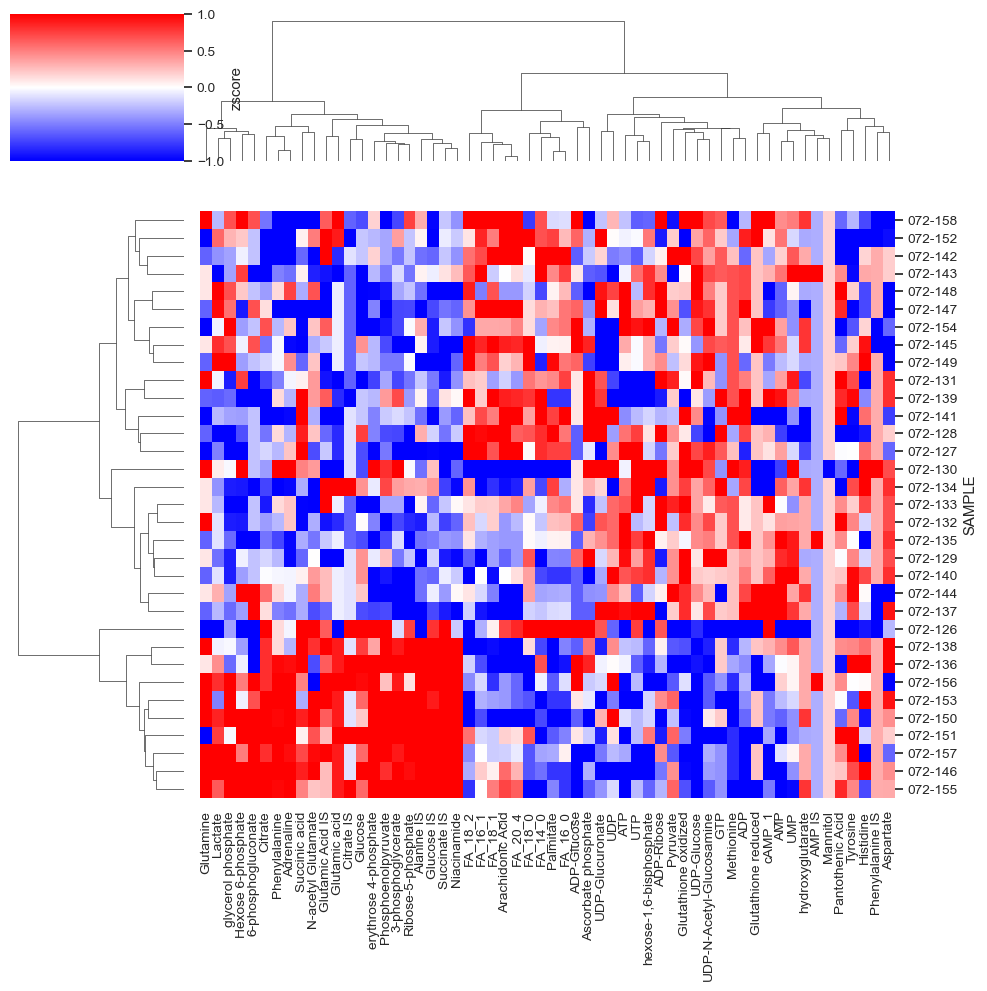

In [12]:
# visualize pattern
linkage_method = 'ward'
distance_metric = 'euclidean'

seaborn.set(font_scale=0.9)
seaborn.clustermap(df_std, 
                   cmap='bwr', col_cluster=True, vmin=-1, vmax=1, 
                   method=linkage_method, metric=distance_metric, 
                   yticklabels=1, xticklabels=1,
                   cbar_kws={'label':'zscore'})
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [13]:
print(df_std['Alanine IS'].mean())
print(df_std['Alanine IS'].std())

-0.004148660062306233
1.0067439114396404


In [14]:
# test
timepoints = [4, 24]
timepoints = [4, 24]
control_label = '0µM'
sample_label = '5 µM epi:nor'
metabolites = df_std.columns

for timepoint in timepoints:
    print('Timepoint {}'.format(timepoint))
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == control_label)
    controls = wdf[rules].index.to_list()
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == sample_label)
    samples = wdf[rules].index.to_list()

    uncorrected = []
    for metabolite in metabolites:
        print('\t', metabolite)
        existing = [control for control in controls if control in df_std.index]
        x = df_std.loc[existing, metabolite]
        existing = [sample for sample in samples if sample in df_std.index]
        y = df_std.loc[samples, metabolite]

        (statistic, pvalue) = scipy.stats.ttest_ind(x, y)
        if numpy.isnan(pvalue) == True:
            pvalue = 1
        uncorrected.append(pvalue)
        if pvalue < 0.05:
            print('\t\t', x.values, y.values, pvalue)
    results = statsmodels.stats.multitest.multipletests(uncorrected, method='fdr_bh')
    print('We found significant metabolites:', sum(results[0]))
    print(results)

    # plot significant
    for i in range(len(metabolites)):
        if results[0][i] == True:
            print(metabolites[i], results[1][i])
            metabolite = metabolites[i]
            a = df_std.loc[controls, metabolite]
            b = df_std.loc[samples, metabolite]
            matplotlib.pyplot.boxplot([a, b])
            matplotlib.pyplot.title('{}; P = {:.3f}'.format(metabolite, results[1][i]))
            matplotlib.pyplot.show()

Timepoint 4
	 Alanine IS
	 AMP IS
	 Citrate IS
	 Glucose IS
	 Glutamic Acid IS
		 [-2.         -0.92676698 -1.26248994] [1.32044463 0.63596114 0.26155614] 0.008541351361605365
	 Phenylalanine IS
	 Succinate IS
		 [-1.08585029 -0.89162505 -0.89162505] [ 1.23593867  0.11146661 -0.07507168] 0.02910535654153331
	 Glutamic acid
		 [-1.70959083 -1.32787549 -1.32787549] [ 0.89165655 -0.83055582 -0.06527427] 0.04747580715424223
	 Hexose 6-phosphate
	 Glutamine
	 Glutathione reduced
	 Glutathione oxidized
	 Histidine
	 Mannitol
	 Methionine
	 Palmitate
	 Phenylalanine
	 Pantothenic Acid
	 Succinic acid
	 ADP
	 AMP
	 ATP
	 cAMP_1
	 ADP-Ribose
	 ADP-Glucose
	 UDP-Glucose
	 UDP-Glucuronate
	 UDP-N-Acetyl-Glucosamine
	 Ascorbate phosphate
	 UMP
	 UDP
	 UTP
	 GTP
	 Arachidonic Acid
	 FA_14_0
	 FA_16_0
	 FA_16_1
	 FA_18_0
	 FA_18_1
	 FA_18_2
	 FA_20_4
	 Glucose
	 hexose-1,6-bisphosphate
	 Lactate
	 Pyruvate
	 3-phosphoglycerate
	 6-phosphogluconate
	 Ribose-5-phosphate
	 Phosphoenolpyruvate
	 erythro

/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531